In [54]:
import torch
import numpy as np
from nerfstudio.cameras.cameras import Cameras
from nerfstudio.cameras.rays import RayBundle
from copy import deepcopy

# First, let's create a gradient-enabled version of NGPModel
class GradientEnabledNGPModel:
    """A wrapper around NGPModel that enables gradient flow through the sampler"""
    
    def __init__(self, original_model):
        # Store the original model
        self._original_model = original_model
        
        # Copy all attributes from the original model
        for attr_name in dir(original_model):
            if not attr_name.startswith('_'):
                setattr(self, attr_name, getattr(original_model, attr_name))
        
        # Access to device, scene_box, etc. comes through the original model
        self.device = original_model.device
        self.collider = None  # Disable collider to ensure gradient flow
        
        # Modify sampler settings to use less memory
        if hasattr(self, 'sampler') and hasattr(self.sampler, 'update_step_size'):
            self.sampler.update_step_size(step_size=original_model.config.render_step_size * 2.0)

    def get_outputs(self, ray_bundle: RayBundle):
        """Override get_outputs to enable gradient flow through the sampler with memory optimization"""
        assert self.field is not None
        num_rays = len(ray_bundle)
        
        # Memory optimizations
        torch.cuda.empty_cache()

        # Create a custom_sampler function to replace the regular sampler
        # This is a critical change to enable gradient flow AND reduce memory usage
        try:
            # CRITICAL: No torch.no_grad() block here to enable gradient flow
            ray_samples, ray_indices = self.sampler(
                ray_bundle=ray_bundle,
                near_plane=self._original_model.config.near_plane,
                far_plane=self._original_model.config.far_plane,
                render_step_size=self._original_model.config.render_step_size * 2.0,  # Use larger step size
                alpha_thre=max(0.05, self._original_model.config.alpha_thre * 2),  # Increase threshold
                cone_angle=self._original_model.config.cone_angle,
            )
        except RuntimeError as e:
            if "CUDA out of memory" in str(e):
                # If we hit OOM, try with even bigger step size and higher threshold
                torch.cuda.empty_cache()
                ray_samples, ray_indices = self.sampler(
                    ray_bundle=ray_bundle,
                    near_plane=self._original_model.config.near_plane,
                    far_plane=self._original_model.config.far_plane,
                    render_step_size=self._original_model.config.render_step_size * 4.0,
                    alpha_thre=0.1,  # Much higher threshold
                    cone_angle=self._original_model.config.cone_angle,
                )
            else:
                raise

        field_outputs = self.field(ray_samples)
        if self._original_model.config.use_gradient_scaling:
            from nerfstudio.model_components.losses import scale_gradients_by_distance_squared
            field_outputs = scale_gradients_by_distance_squared(field_outputs, ray_samples)

        from nerfstudio.field_components.field_heads import FieldHeadNames
        import nerfacc
        
        # Accumulation
        packed_info = nerfacc.pack_info(ray_indices, num_rays)
        weights = nerfacc.render_weight_from_density(
            t_starts=ray_samples.frustums.starts[..., 0],
            t_ends=ray_samples.frustums.ends[..., 0],
            sigmas=field_outputs[FieldHeadNames.DENSITY][..., 0],
            packed_info=packed_info,
        )[0]
        weights = weights[..., None]

        rgb = self.renderer_rgb(
            rgb=field_outputs[FieldHeadNames.RGB],
            weights=weights,
            ray_indices=ray_indices,
            num_rays=num_rays,
        )
        
        # Skip computing depth and accumulation to save memory
        # Just return RGB which is what we need for the loss
        outputs = {
            "rgb": rgb,
        }
        
        # Force clean up
        torch.cuda.empty_cache()
        
        return outputs

    def __getattr__(self, name):
        """Fallback to the original model for any attributes we don't override"""
        return getattr(self._original_model, name)

In [55]:
class BrainSurfaceAligner:
    def __init__(
        self,
        pipeline,
        target_image,
        initial_transform=None,
        learning_rate=0.01,
        image_height=512,
        image_width=512,
        max_iterations=1000,
        convergence_threshold=1e-5,
        low_res_factor=4,  # Downsample factor to reduce memory usage
    ):
        self.pipeline = pipeline
        
        # Force CUDA memory cleanup
        torch.cuda.empty_cache()
        
        # Downsample images for memory efficiency
        self.low_res_factor = low_res_factor
        self.full_image_height = image_height
        self.full_image_width = image_width
        
        # Calculate reduced dimensions
        self.image_height = image_height // low_res_factor
        self.image_width = image_width // low_res_factor
        
        # Replace the model with a gradient-enabled version
        original_model = pipeline.model
        gradient_model = GradientEnabledNGPModel(original_model)
        
        # Store the model
        self.model = gradient_model
        
        self.device = self.model.device
        
        # Resize target image for more efficient processing
        if low_res_factor > 1 and target_image.shape[0] == self.full_image_height:
            import torch.nn.functional as F
            target_image_resized = F.interpolate(
                target_image.permute(2, 0, 1).unsqueeze(0),  # [1, C, H, W]
                size=(self.image_height, self.image_width),
                mode='bilinear',
                align_corners=False
            ).squeeze(0).permute(1, 2, 0)  # [H, W, C]
            self.target_image = target_image_resized.to(self.device)
        else:
            self.target_image = target_image.to(self.device)
            
        self.max_iterations = max_iterations
        self.convergence_threshold = convergence_threshold

        self.hook_handles = []
        
        # Freeze all model parameters to ensure we only optimize the camera
        for param in original_model.parameters():
            param.requires_grad = False
            
        # Initialize camera parameters from provided transform or with defaults
        if initial_transform is None:
            # Default transformation looking along -z axis
            initial_transform = torch.eye(4, dtype=torch.float32)
        
        # Extract rotation and translation as separate parameters for optimization
        # Clone to ensure we're not sharing memory with the input tensor
        self.camera_rotation = torch.nn.Parameter(
            initial_transform[:3, :3].clone().detach().to(self.device)
        )
        self.camera_translation = torch.nn.Parameter(
            initial_transform[:3, 3].clone().detach().to(self.device)
        )
        
        # Create optimizer for camera parameters only
        self.optimizer = torch.optim.Adam(
            [self.camera_rotation, self.camera_translation], 
            lr=learning_rate
        )
        
        # Loss function
        self.loss_fn = torch.nn.MSELoss()
        
    def get_camera_to_world(self):
        """Create transformation matrix from current parameters in a way that preserves gradients"""
        # Create a new identity matrix on the correct device
        bottom_row = torch.tensor([[0.0, 0.0, 0.0, 1.0]], device=self.device)
        
        # Explicitly construct the top part of the matrix
        # This preserves gradients from the parameters
        rotation = self.camera_rotation  # Shape: [3, 3]
        translation = self.camera_translation.reshape(3, 1)  # Shape: [3, 1]
        
        # Combine rotation and translation
        top_part = torch.cat([rotation, translation], dim=1)  # Shape: [3, 4]
        
        # Combine with bottom row
        c2w = torch.cat([top_part, bottom_row], dim=0)  # Shape: [4, 4]
        
        return c2w
        
    def create_camera(self):
        """Create nerfstudio Camera object from current parameters"""
        # Create camera_to_worlds with shape [1, 3, 4]
        c2w = self.get_camera_to_world()[:3, :4].unsqueeze(0)
        
        # Use camera parameters from the first camera in training dataset 
        # or default parameters if not available
        try:
            fx = self.pipeline.datamanager.train_dataset.cameras.fx[0]
            fy = self.pipeline.datamanager.train_dataset.cameras.fy[0]
            cx = self.pipeline.datamanager.train_dataset.cameras.cx[0]
            cy = self.pipeline.datamanager.train_dataset.cameras.cy[0]
            width = self.pipeline.datamanager.train_dataset.cameras.width[0]
            height = self.pipeline.datamanager.train_dataset.cameras.height[0]
        except (AttributeError, IndexError):
            # Default camera intrinsics if not available
            fx = torch.tensor([1000.0], device=self.device)
            fy = torch.tensor([1000.0], device=self.device)
            cx = torch.tensor([self.image_width/2], device=self.device)
            cy = torch.tensor([self.image_height/2], device=self.device)
            width = torch.tensor([self.image_width], device=self.device)
            height = torch.tensor([self.image_height], device=self.device)
            
        camera = Cameras(
            camera_to_worlds=c2w,
            fx=fx,
            fy=fy,
            cx=cx,
            cy=cy,
            width=width,
            height=height,
        )
        return camera

    def render_view(self, chunk_size=128):
        """Render an image using the current camera parameters while ensuring gradient flow
           Uses very small chunks to avoid memory issues"""
        # Clear previous hooks and empty cache
        self.hook_handles = []
        torch.cuda.empty_cache()
        
        # Generate a RayBundle directly from the camera parameters
        camera = self.create_camera()
        
        # IMPORTANT: Make sure camera dimensions match our expected output dimensions
        camera.height = torch.tensor([self.image_height], device=self.device)
        camera.width = torch.tensor([self.image_width], device=self.device)
        
        ray_bundle = camera.generate_rays(camera_indices=0, keep_shape=True)
        
        # Reshape the ray bundle to [H*W, 3] format for processing
        H, W = self.image_height, self.image_width
        ray_origins = ray_bundle.origins.reshape(-1, 3)
        ray_directions = ray_bundle.directions.reshape(-1, 3)
        
        # Create pixel_area, camera_indices, and times with minimal memory usage
        ones = torch.ones_like(ray_origins[..., :1])
        zeros_int = torch.zeros_like(ray_origins[..., 0], dtype=torch.int64)
        zeros_float = torch.zeros_like(ray_origins[..., :1])
        
        # Process in much smaller chunks to avoid OOM
        num_rays = ray_origins.shape[0]
        rgb_chunks = []
        
        # Use a much smaller chunk size to avoid memory issues
        chunk_size = min(chunk_size, 128)  # Significantly reduce chunk size
        
        for i in range(0, num_rays, chunk_size):
            end_idx = min(i + chunk_size, num_rays)
            chunk_size_actual = end_idx - i
            
            # Extract chunks of each component
            chunk_origins = ray_origins[i:end_idx]
            chunk_directions = ray_directions[i:end_idx]
            chunk_pixel_area = ones[i:end_idx] if ray_bundle.pixel_area is not None else ones[:chunk_size_actual]
            chunk_camera_indices = zeros_int[i:end_idx] if ray_bundle.camera_indices is not None else zeros_int[:chunk_size_actual]
            chunk_times = zeros_float[i:end_idx] if ray_bundle.times is not None else zeros_float[:chunk_size_actual]
            
            # Create chunk ray bundle
            chunk_ray_bundle = RayBundle(
                origins=chunk_origins,
                directions=chunk_directions,
                pixel_area=chunk_pixel_area,
                camera_indices=chunk_camera_indices,
                times=chunk_times,
            )
            
            # Run model inference with gradient tracking
            outputs = self.model.get_outputs(chunk_ray_bundle)
            rgb_chunks.append(outputs["rgb"].detach().clone())  # Detach to free memory
            
            # Force garbage collection after each chunk
            if i % (chunk_size * 8) == 0:
                torch.cuda.empty_cache()
        
        # Combine chunks and reshape back to image dimensions
        all_rgb = torch.cat(rgb_chunks, dim=0)
        all_rgb = all_rgb.reshape(H, W, 3)
        
        # Make sure the output has requires_grad=True for backprop
        if not all_rgb.requires_grad:
            all_rgb.requires_grad = True
            
        # Clean up memory
        torch.cuda.empty_cache()
            
        return all_rgb
    
    def optimize_step(self):
        """Perform one optimization step with better gradient tracking"""
        self.optimizer.zero_grad()
        
        # Empty CUDA cache before rendering
        torch.cuda.empty_cache()
        
        # Add gradient hooks for debugging
        rotation_hook = self.camera_rotation.register_hook(
            lambda grad: print(f"Rotation grad in hook: {grad.norm().item() if grad is not None else None}")
        )
        translation_hook = self.camera_translation.register_hook(
            lambda grad: print(f"Translation grad in hook: {grad.norm().item() if grad is not None else None}")
        )
        
        # Render image with current camera parameters
        rendered_image = self.render_view(chunk_size=1024)
        
        # Verify that rendered_image has gradients before computing loss
        print(f"Rendered image requires_grad: {rendered_image.requires_grad}")
        
        # Compute loss against target image
        loss = self.loss_fn(rendered_image, self.target_image)
        print(f"Loss value: {loss.item()}")
        
        # Backpropagate 
        loss.backward()
        
        # Clean up hooks
        rotation_hook.remove()
        translation_hook.remove()
        
        # Check gradients for debugging
        if self.camera_rotation.grad is not None:
            print(f"Rotation grad norm: {self.camera_rotation.grad.norm().item()}")
        else:
            print("Rotation grad is None")
            
        if self.camera_translation.grad is not None:
            print(f"Translation grad norm: {self.camera_translation.grad.norm().item()}")
        else:
            print("Translation grad is None")
        
        # Update camera parameters only if we have gradients
        if self.camera_rotation.grad is not None and self.camera_translation.grad is not None:
            self.optimizer.step()
            
            # Orthogonalize rotation matrix to ensure it remains a valid rotation
            with torch.no_grad():
                u, _, v = torch.svd(self.camera_rotation)
                self.camera_rotation.data = u @ v.T
        else:
            print("Skipping optimization step due to missing gradients")
        
        # Explicitly clean up memory
        torch.cuda.empty_cache()
            
        return loss.item(), rendered_image
        
    def run_optimization(self, callback=None):
        """Run the full optimization process"""
        losses = []
        images = []
        
        for i in range(self.max_iterations):
            try:
                loss, rendered_image = self.optimize_step()
                losses.append(loss)
                
                if callback and i % 10 == 0:
                    callback(i, loss, rendered_image, self.get_camera_to_world())
                    
                if i % 10 == 0:
                    print(f"Iteration {i}, Loss: {loss:.6f}")
                    images.append(rendered_image.detach().cpu().numpy())
                    
                # Check for convergence
                if i > 20 and abs(losses[-1] - losses[-20]) < self.convergence_threshold:
                    print(f"Converged at iteration {i}")
                    break
            except Exception as e:
                print(f"Error in iteration {i}: {e}")
                import traceback
                traceback.print_exc()
                break
                
        return {
            "final_loss": losses[-1] if losses else float('inf'),
            "loss_history": losses,
            "image_history": images,
            "final_transform": self.get_camera_to_world().detach().cpu().numpy(),
            "final_rotation": self.camera_rotation.detach().cpu().numpy(),
            "final_translation": self.camera_translation.detach().cpu().numpy(),
        }

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from outputs/0_065_cat5_2/instant-ngp/2024-08-20_140044/nerfstudio_models/step-000018000.ckpt

Rendered image requires_grad: True
Loss value: 0.3106426000595093
Rotation grad is None
Translation grad is None
Skipping optimization step due to missing gradients
Current transform:
tensor([[ -0.1655,   0.1717,  -0.9711, -80.7367],
        [ -0.9757,   0.1149,   0.1866,  15.5147],
        [  0.1437,   0.9784,   0.1485,  12.3481],
        [  0.0000,   0.0000,   0.0000,   1.0000]], device='cuda:0',
       grad_fn=<CatBackward0>)
Iteration 0, Loss: 0.310643
Rendered image requires_grad: True
Loss value: 0.3106426000595093
Rotation grad is None
Translation grad is None
Skipping optimization step due to missing gradients
Rendered image requires_grad: True
Loss value: 0.3106426000595093
Rotation grad is None
Translation grad is None
Skipping optimization step due to missing gradients
Rendered image requires_grad: True
Loss value: 0.3106426000595093
Rotation grad is None
Translation grad is None
Skipping optimization step due to missing gradients
Rendered image requires_grad: True
Loss valu

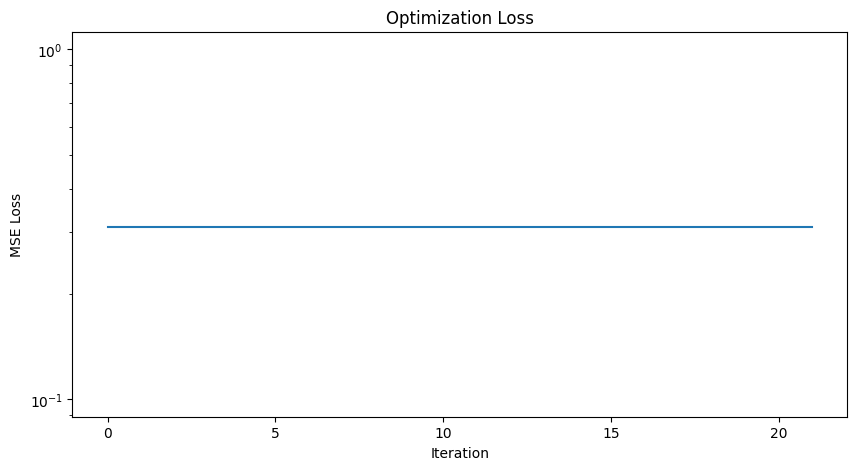

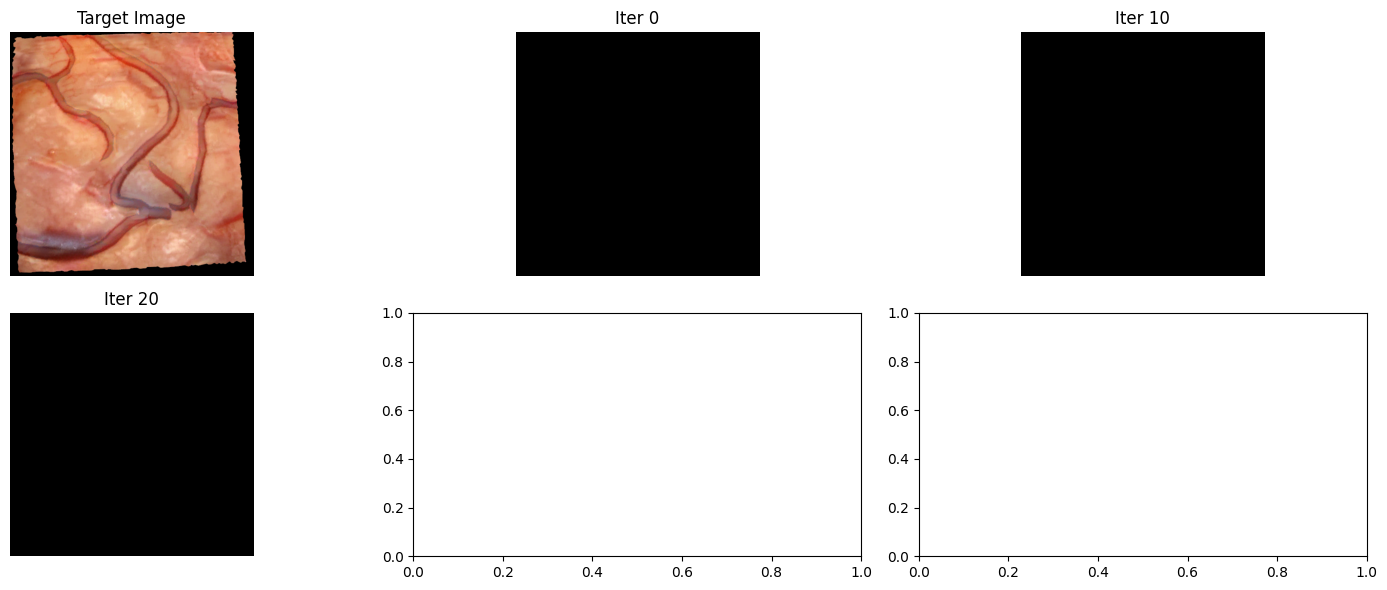

In [56]:
import torch
from nerfstudio.utils.eval_utils import eval_setup
import numpy as np
import cv2
from pathlib import Path

# 1. Load your pre-trained model
config_path = Path(
    "/n/home10/dpodolskyi/neural-registration/outputs/0_065_cat5_2/instant-ngp/2024-08-20_140044/config.yml")
_, pipeline, _, _ = eval_setup(config_path=config_path, test_mode="inference")

# 2. Prepare your target image (real brain surface image)
target_image_path = "/n/home10/dpodolskyi/neural-registration/data/datasets/0_065_cat5_2.0/images/4.png"
target_image = cv2.imread(target_image_path)
target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB)
target_image = torch.from_numpy(target_image).float() / 255.0  # Normalize to [0,1]

# Ensure target image has the right shape
image_height, image_width = target_image.shape[:2]

# 3. Set your initial transformation matrix (good starting point)
initial_transform = torch.tensor([
    [-0.16551750084030392, 0.17173068552312126, -0.9711398089695112, -80.73672706466026],
    [-0.9756847655052445, 0.11494663876681419, 0.18661861803471735, 15.51473463480075],
    [0.14367740002017088, 0.9784149640546033, 0.14852933325600515, 12.348141976499424],
    [0, 0, 0, 1],
], dtype=torch.float32)

# 4. Run the optimization with memory-efficient settings
aligner = BrainSurfaceAligner(
    pipeline=pipeline,
    target_image=target_image,
    initial_transform=initial_transform,
    learning_rate=0.001,  # Start with a smaller learning rate
    image_height=image_height,
    image_width=image_width,
    max_iterations=500,
    low_res_factor=4,  # Use lower resolution for optimization to save memory
)

# Optional visualization callback
def viz_callback(iteration, loss, image, transform):
    # Save current render
    if iteration % 50 == 0:
        img_np = (image.detach().cpu().numpy() * 255).astype(np.uint8)
        cv2.imwrite(f"iteration_{iteration}.png", cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR))
        print(f"Current transform:\n{transform}")

# Run optimization with try-except to catch any errors
try:
    results = aligner.run_optimization(callback=viz_callback)
    
    # 5. Use the optimized camera parameters
    final_transform = results["final_transform"]
    print(f"Final transformation matrix:\n{final_transform}")
    print(f"Final loss: {results['final_loss']}")
    
    # 6. Visualize the optimization progress (optional)
    import matplotlib.pyplot as plt
    
    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(results["loss_history"])
    plt.title("Optimization Loss")
    plt.xlabel("Iteration")
    plt.ylabel("MSE Loss")
    plt.yscale("log")
    plt.savefig("loss_curve.png")
    
    # Create a grid of images to show progression
    if len(results["image_history"]) > 0:
        fig, axes = plt.subplots(2, min(5, len(results["image_history"])), figsize=(15, 6))
        axes = axes.flatten()
        
        # Show target image in first spot
        axes[0].imshow(target_image.cpu().numpy())
        axes[0].set_title("Target Image")
        axes[0].axis('off')
        
        # Show progressing renders
        for i, img in enumerate(results["image_history"]):
            if i >= len(axes) - 1:
                break
            axes[i+1].imshow(img)
            axes[i+1].set_title(f"Iter {i*10}")
            axes[i+1].axis('off')
            
        plt.tight_layout()
        plt.savefig("optimization_progress.png")
        
except Exception as e:
    print(f"Optimization failed: {e}")
    import traceback
    traceback.print_exc()